# 线性回归（二）

<font color=blue size=4>1.课堂实验任务</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<span style="color:purple">1) 使用pandas库的read_csv()函数(可以参考[pandas的官方文档](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html))将训练数据集'train.csv'和测试数据集'test.csv'载入到Dataframe对象中。</span>

In [2]:
# Your code here

#读取数据集
train_frame = pd.read_csv('train.csv')
test_frame = pd.read_csv('test.csv')

#转化成numpy矩阵
train = np.array(train_frame)
test = np.array(test_frame)

<span style="color:purple">2) 假设模型为一元线性回归模型$\hat{y}=wx+b$, 损失函数为$l(w,b)=\frac{1}{2}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$, 其中$\hat{y}^{(i)}$表示第$i$个样本的预测值，$y^{(i)}$表示第$i$个样本的实际标签值, $m$为训练集中样本的个数。求出使得损失函数最小化的参数$w$和$b$。</span>

方法① 

将$l(w,b)$分别对$w$和$b$求导，得到
$$
\frac{\partial l(w,b)}{\partial w}=w\sum_{i=1}^m x_i^2 -\sum_{i=1}^m (y_i-b)x_i,
$$
$$
\frac{\partial l(w,b)}{\partial b}=mb -\sum_{i=1}^m (y_i-wx_i),
$$
令上述两式为零即可得到$w$和$b$的解析解：
$$
w=\frac{\sum_{i=1}^m y_i (x_i-\bar{x})}{\sum_{i=1}^m x_i^2-\frac{1}{m}(\sum_{i=1}^m x_i)^2},
$$
$$
b=\frac{1}{m}\sum_{i=1}^m(y_i-wx_i),
$$
其中$\bar{x}=\frac{1}{m}\sum_{i=1}^m x_i$为$x$的均值。



方法② 梯度下降法。手动实现梯度下降法(不使用机器学习框架，如PyTorch、TensorFlow等)来进行模型的训练。算法步骤如下：1.初始化模型参数$w$和$b$的值；2.在负梯度的方向上更新参数(批量梯度下降、小批量随机梯度下降或者随机梯度下降均可)，并不断迭代这一步骤，更新公式(以小批量随机梯度下降为例)可以写成：$$w\gets w-\frac{\eta}{\left|B\right|}\sum_{i\in{B}}x^{(i)}(wx^{(i)}+b-y^{(i)})$$, 和$$b\gets b-\frac{\eta}{\left|B\right|}\sum_{i\in{B}}(wx^{(i)}+b-y^{(i)})$$， 其中$\eta$表示学习率,$B$表示每次迭代中随机抽样的小批量，$\left|B\right|$则表示$B$中的样本数量。3. 终止条件为迭代次数达到某一上限或者参数更新的幅度小于某个阈值。

In [3]:
# 方法①
def func_1():
    x_average = np.mean(train[:, 0])
    omega = np.sum((train[:, 0] - x_average) * train[:, 1]) / (np.sum(train[:, 0] ** 2) - np.sum(train[:, 0]) ** 2 / len(train))
    b = np.mean(train[:, 1] - omega * train[:, 0])
    return omega, b

# 方法②
# 将数据集分成k个mini_batch
def func_2(omega_init, b_init, k, learning_rate, threshold):
    def get_mini_batches(train, k):
        np.random.shuffle(train)
        mini_batches = [train[i:i + k] for i in range(0, len(train), k)]
        return mini_batches
    
    mini_batches = get_mini_batches(train, k)

    def gradient_descent(omega, b, mini_batches):
        # omega的更新公式
        def omega_gd(omega, b, mini_batch):
            total = 0
            for x, y in mini_batch:
                total += x * (omega * x + b - y)
            return omega - learning_rate * total / len(mini_batch)

        # b的更新公式
        def b_gd(omega, b, mini_batch):
            total = 0
            for x, y in mini_batch:
                total += omega * x + b - y
            return b - learning_rate * total / len(mini_batch)
        
        while True:
            random_index = np.random.randint(0, len(mini_batches))
            mini_batch = mini_batches[random_index]
            omega_new, b_new = omega_gd(omega, b, mini_batch), b_gd(omega, b, mini_batch)
            # 终止条件为参数更新的幅度小于阈值threshold
            if abs(omega_new - omega) < threshold and abs(b_new - b) < threshold:
                break
            omega, b = omega_new, b_new
        return omega, b
    return gradient_descent(omega_init, b_init, mini_batches)

omega_1, b_1 = func_1()
print('func_1: omega = %f, b = %f' % (omega_1, b_1))

#omega和b为任意初始值，k取10，学习率取0.01，阈值取0.0001
k = 10
learning_rate = 0.01
threshold = 0.0001

omega_2, b_2 = func_2(1, 1, k, learning_rate, threshold)
print('func_2: omega = %f, b = %f' % (omega_2, b_2))

func_1: omega = 3.041479, b = 4.906074
func_2: omega = 3.088664, b = 4.833292


方法③ 

用矩阵表示，假设数据集有$m$个样本，特征有$n$维$。X=\left[ \begin{matrix} x_{11} & x_{12} & \cdots & x_{1n} & 1 \\
                         x_{21} & x_{22} & \cdots & x_{2n} & 1 \\
                         \vdots & \vdots &      & \vdots & \vdots \\
                         x_{m1} & x_{m2} & \cdots & x_{mn} & 1 \end{matrix} \right]$,
        实际标签$Y=\left[ \begin{matrix} y_{1} \\
                         y_{2} \\
                         \vdots \\
                         y_{m}\end{matrix} \right]$,
        参数$B=\left[ \begin{matrix} w_{1} \\
                         w_{2} \\
                         \vdots \\
                         w_{n} \\
                         b\end{matrix} \right]$，则解析解为$B^*=(X^T X)^{-1}X^T Y$。推导过程可参考[这篇文章](https://zhuanlan.zhihu.com/p/74157986)。

<span style="color:purple">3) 使用求解出来的线性回归模型对测试数据集'test.csv'进行预测，输出可视化结果（比如用seaborn或者matplotlib等可视化库来画出测试数据的散点图以及训练好的模型函数图像）。</span>

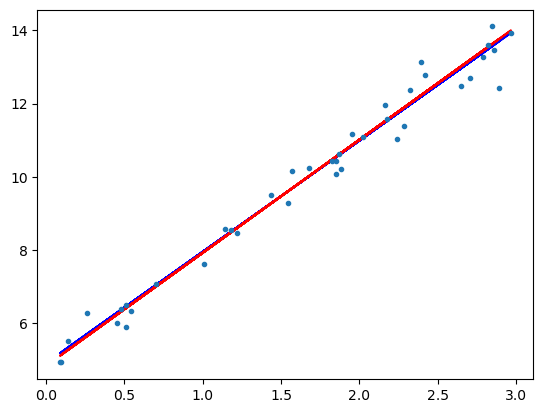

In [4]:
# Your code here
#A=np.array([[1,2,3],[4,5,6],[7,8,9]])
#x = A[0, :] #从一个矩阵中提取出一行作为一个向量
#y1 = np.array([2, 3, 5])
#plt.plot(x, y1) #画出折线图
#y2 = np.array([2.5, 2.8, 5.3])
#plt.plot(x, y2, '.') #画出散点图
#plt.show()

test_x = test[:, 0]
test_y = test[:, 1]

train_y_1 = omega_1 * test_x + b_1
train_y_2 = omega_2 * test_x + b_2

plt.plot(test_x, train_y_1, 'b')
plt.plot(test_x, train_y_2, 'r')
plt.plot(test_x, test_y, '.')
plt.show()

<span style="color:purple">4) 在训练数据集'train2.csv'上求一个三元线性回归模型$\hat{y}=w_0 + w_1 x_1 + w_2 x_2 + w_3 x_3$的使得损失函数$l(w_0,w_1,w_2,w_3)=\frac{1}{2}\sum_{i=1}^m(\hat{y}^{(i)}-y^{(i)})^2$最小的参数$w_0,w_1,w_2$以及$w_3$。并在测试数据集'test2.csv'上进行预测，输出预测结果的均方误差$MSE(\hat{y},y)=\frac{1}{n}\sum^n_{i=1}(y^{(i)}-\hat{y}^{(i)})^2$, $n$为测试集中样本个数。</span>

方法① 同2)中的方法③。

方法② 类似2)中的方法②。算法步骤如下：1.初始化模型参数$w_0,w_1,w_2,w_3$的值；2.在负梯度的方向上更新参数(批量梯度下降、小批量随机梯度下降或者随机梯度下降均可)，并不断迭代这一步骤，更新公式(以小批量随机梯度下降为例)可以写成：$$w_j\gets w_j-\frac{\eta}{\left|B\right|}\sum_{i\in{B}}x_j^{(i)}(w_0 + w_1 x_1^{(i)}+w_2 x_2^{(i)}+w_3 x_3^{(i)}-y^{(i)}), j=0,1,2,3$$, 其中$x_0^{(i)}=1$， 其中$\eta$表示学习率,$B$表示每次迭代中随机抽样的小批量，$\left|B\right|$则表示$B$中的样本数量。3. 终止条件为迭代次数达到某一上限或者参数更新的幅度小于某个阈值。

In [15]:
# Your code here

train_frame = pd.read_csv('train2.csv')
test_frame = pd.read_csv('test2.csv')

train = np.array(train_frame)
test = np.array(test_frame)

# 将数据集分成k个mini_batch
def get_mini_batches(train, k):
    np.random.shuffle(train)
    mini_batches = [train[i:i + k] for i in range(0, len(train), k)]
    return mini_batches

k = 10
mini_batches = get_mini_batches(train, k)

# 学习率
learning_rate = 0.01
# 阈值 >= 0.001
threshold = 0.001

def gradient_descent(omega, mini_batches):
    # omega的更新公式
    def omega_gd(omega, mini_batch):
        res = omega.copy()
        mini_batch_with_x0 = np.insert(mini_batch, 0, 1, axis=1)
        total = 0
        for i in range(len(res)):
            for row in mini_batch_with_x0:
                xj = row[i]
                total += xj * (omega[0] + omega[1] * row[1] + omega[2] * row[2] + omega[3] * row[3] - row[4])
            res[i] -= learning_rate * total / len(mini_batch)
        return res

    while True:
        random_index = np.random.randint(0, len(mini_batches))
        mini_batch = mini_batches[random_index]
        omega_new = omega_gd(omega, mini_batch)
        flag = True
        # 终止条件为参数更新的幅度小于阈值threshold
        for x, y in zip(omega_new, omega):
            if abs(x - y) >= threshold:
                flag = False
                break
        omega = omega_new
        if flag:
            break
    return omega

#omega任意初始值
omega = [1, 1, 1, 1]
omega = gradient_descent(omega, mini_batches)

test_x = test[:, :3]
train_y = [omega[0] + omega[1] * x1 + omega[2] * x2 + omega[3] * x3 for x1, x2, x3 in test_x]
test_y = test[:, 3]
MSE = np.sum((test_y - train_y) ** 2) / len(test_y)
print('omega = ' + str(omega))
print('MSE = ' + str(MSE))




omega = [4.483974672173968, 1.2308467502840124, 2.17258322878662, 3.20945679025689]
MSE = 0.383779830817784


<font color=blue size=4>2.相关链接</font>

1.实验报告提交链接(有效期直至9.15 14:20): https://send2me.cn/211f55kq/Sgav4JPN0foh9Q

2.实验课件获取链接: https://www.jianguoyun.com/p/DWcqLm4Qp5WhChjZi5sFIAA